<a href="https://colab.research.google.com/github/FabioMMaia/AutoTune_CNN_TransferLearning_adaptation/blob/main/AutoTune_VGG16_CompleteArc_WithFCLayers_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !sudo apt-get update -y
# !sudo apt-get install python3.9 -y
# !echo 2 | sudo update-alternatives --config python3 #'echo 2' auto-inputs '2' so that it doesn't have to be done manually

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install GPyOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 36.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha256=3d28ab6dc63e574328093893683ea4d7229ee329b2c97692586abba2a5822759
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3420829 sha256=ae107aa98f4639990d82ed1c6f9f58953de442fbe3ea7e2d11ccac67d7f3dec6
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102543 sha256=6c477a6251ca6414031da2cf

In [ ]:
# !pip install keras==2.2.5

In [ ]:
import time
import os
import math
import numpy as np
import pandas as pd
import GPyOpt
import keras
import random
import math
from itertools import product, combinations
from collections import OrderedDict
from keras.preprocessing import image
from keras import layers, models, optimizers, callbacks, initializers, activations
from keras.applications import VGG16
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
reverse_list = lambda l: list(reversed(l))

DATA_FOLDER = r'/content/drive/MyDrive/Mestrado/SIN5006/Apresentação II/Codigo/CalTech101'
# DATA_FOLDER = "CalTech101"
TRAIN_PATH = os.path.join(DATA_FOLDER, "training") # Path for training data
VALID_PATH = os.path.join(DATA_FOLDER, "validation") # Path for validation data
NUMBER_OF_CLASSES = len(os.listdir(TRAIN_PATH)) # Number of classes of the dataset
EPOCHS = 50
RESULTS_PATH = os.path.join(r'/content/drive/MyDrive/Mestrado/SIN5006/Apresentação II/Codigo/', "AutoConv_VGG16_randomsearch_log" + "_autoconv_v10.csv") # The path to the results file
# RESULTS_PATH = os.path.join("AutoConv_VGG16_new1", "AutoConv_VGG16_randomsearch_log_" + DATA_FOLDER.split('/')[-1] + "_autoconv_v10.csv") # The path to the results file

# Creating generators from training and validation data
batch_size=8 # the mini-batch size to use for the dataset
datagen = image.ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input) # creating an instance of the data generator
train_generator = datagen.flow_from_directory(TRAIN_PATH, target_size=(224, 224), batch_size=batch_size) # creating the generator for training data
valid_generator = datagen.flow_from_directory(VALID_PATH, target_size=(224, 224), batch_size=batch_size) # creating the generator for validation data

# creating callbacks for the model -- ajusted (Fabio): monitor by val_accuracy
reduce_LR = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=np.sqrt(0.01), cooldown=0, patience=5, min_lr=0.5e-10)

# Creating a CSV file if one does not exist
try:
    log_df = pd.read_csv(RESULTS_PATH, header=0, index_col=['index'])
except FileNotFoundError:
    # log_df = pd.DataFrame(columns=['index', 'activation', 'weight_initializer', 'num_layers_tuned', 'num_fc_layers', 'num_neurons', 'dropouts', 'filter_sizes', 'num_filters', 'stride_sizes', 'pool_sizes', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
    log_df = pd.DataFrame(columns=['index', 'activation', 'weight_initializer', 'num_layers_tuned', 'num_fc_layers', 'num_neurons', 'dropouts', 'filter_sizes', 'num_filters', 'stride_sizes', 'pool_sizes', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'trainable_params', 'frozen_params', 'time'])
    log_df = log_df.set_index('index')


# utility function
def upsample(shape, target_size=5):
    upsampling_factor = math.ceil(target_size / shape[1])
    return layers.UpSampling2D(size=(upsampling_factor, upsampling_factor))


# function to modify architecture for current hyperparams
# model: The original model to be modified.
# index: The index of the layer in the model where modifications will start.
# architecture: A list describing the desired architecture.
# num_filters, filter_sizes, pool_sizes, acts: Lists of hyperparameters specific to each layer in the architecture.
# zero_pads: Not used in this function.
# optim_neurons, optim_dropouts: Lists of units and dropout rates for fully connected layers.

def get_model_conv(model,
                   index,
                   architecture,
                   num_filters,
                   filter_sizes,
                   pool_sizes,
                   acts,
                   zero_pads,
                   optim_neurons,
                   optim_dropouts):

    X = model.layers[index - 1].output

    for i in range(len(architecture)):
        global_index = index + i
        if architecture[i] == 'add':
            continue

        if architecture[i] == 'conv':
            assert type(model.layers[global_index]) == layers.Conv2D
            num_filter = num_filters.pop(0)
            filter_size = filter_sizes.pop(0)
            act = acts.pop(0)
            try:
                X = layers.Conv2D(filters=int(num_filter), kernel_size=(int(filter_size), int(filter_size)), kernel_initializer='he_normal', activation=act)(X)
            except:
                X = upsample(X.shape)(X)
                X = layers.Conv2D(filters=int(num_filter), kernel_size=(int(filter_size), int(filter_size)), kernel_initializer='he_normal', activation=act)(X)
        elif architecture[i] == 'maxpool':
            assert type(model.layers[global_index]) == layers.MaxPooling2D
            pool_size = pool_sizes.pop(0)
            X = layers.MaxPooling2D(pool_size=int(pool_size))(X)
        elif architecture[i] == 'globalavgpool':
            assert type(model.layers[global_index]) == layers.GlobalAveragePooling2D
            X = layers.GlobalAveragePooling2D()(X)
        elif architecture[i] == 'batch':
            assert type(model.layers[global_index]) == layers.BatchNormalization
            X = layers.BatchNormalization()(X)
        elif architecture[i] == 'activation':
            assert type(model.layers[global_index]) == layers.Activation
            X = layers.Activation(acts.pop(0))(X)
        elif architecture[i] == 'flatten':
            X = layers.Flatten()(X)

    for units, dropout in zip(optim_neurons, optim_dropouts):
        X = layers.Dense(units, kernel_initializer='he_normal', activation=acts.pop(0))(X)
        X = layers.BatchNormalization()(X)
        X = layers.Dropout(float(dropout))(X)

    X = layers.Dense(NUMBER_OF_CLASSES, activation='softmax', kernel_initializer='he_normal')(X)
    return models.Model(inputs=model.inputs, outputs=X)


base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=True)
for i in range(len(base_model.layers)):
    base_model.layers[i].trainable = False

# training original model
X = base_model.layers[-2].output
X = layers.Dense(NUMBER_OF_CLASSES, activation='softmax', kernel_initializer='he_normal')(X)
to_train_model = models.Model(inputs=base_model.inputs, outputs=X)
to_train_model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])

history = to_train_model.fit_generator(
    train_generator,
    validation_data=valid_generator, epochs=EPOCHS,
    steps_per_epoch=len(train_generator) / batch_size,
    validation_steps=len(valid_generator), callbacks=[reduce_LR]
)

# freezing the layers of the model
base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=True)
base_model = models.Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
for i in range(len(base_model.layers)):
    base_model.layers[i].trainable = False



Found 303 images belonging to 101 classes.
Found 303 images belonging to 101 classes.
Epoch 1/50
4/4 [==============================] - 3s 633ms/step - loss: 5.9551 - accuracy: 0.0513 - val_loss: 5.8497 - val_accuracy: 0.0264 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 2s 553ms/step - loss: 5.8199 - accuracy: 0.0750 - val_loss: 5.6390 - val_accuracy: 0.0330 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 2s 555ms/step - loss: 5.0734 - accuracy: 0.0500 - val_loss: 5.4863 - val_accuracy: 0.0462 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 2s 558ms/step - loss: 4.8724 - accuracy: 0.0750 - val_loss: 5.2911 - val_accuracy: 0.0495 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 2s 564ms/step - loss: 4.6561 - accuracy: 0.1750 - val_loss: 5.1161 - val_accuracy: 0.0495 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 2s 566ms/step - loss: 4.8354 - accuracy: 0.1000 - val_loss: 4.9694 - val_accuracy: 0.0594 - lr: 0.0

In [9]:

# optimize layers
best_acc = 0

# list of layers not considered in optimization
meaningless = [
    layers.Activation,
    layers.GlobalAveragePooling2D,
    layers.ZeroPadding2D,
    layers.Add,
    layers.Flatten
]

# search spaces for each kind of hyperparam
filter_size_space = [1, 3]
num_filter_space = [32, 64, 128, 256]
pool_size_space = [2, 3]
units_space = [2 ** j for j in range(6, 11)]
dropouts_space = np.arange(0, 1, step=0.1).tolist()
pad_size_space = list(range(1, 5))
acts_space = [
    activations.relu,
    activations.sigmoid,
    activations.tanh,
    activations.elu,
    activations.selu
]

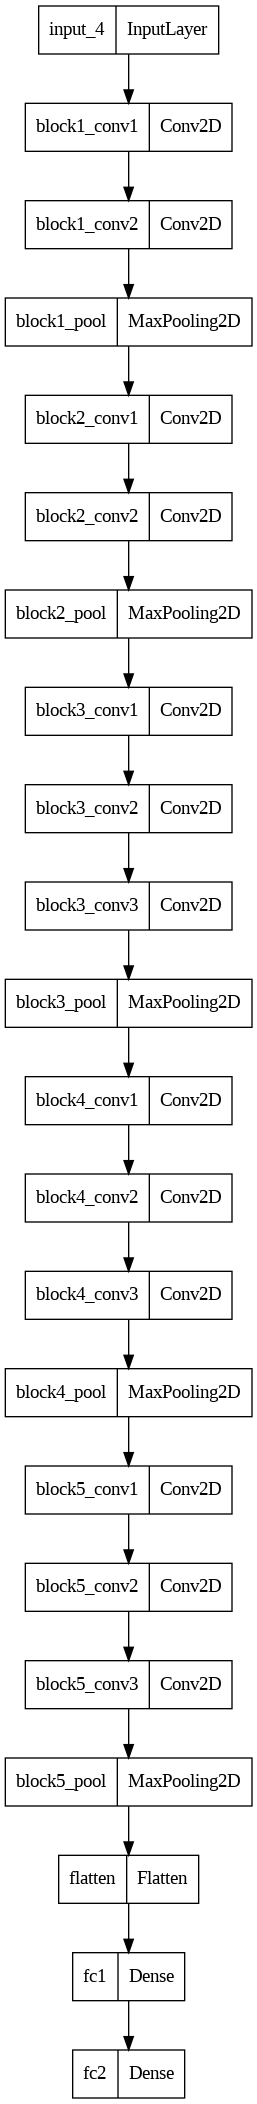

In [14]:
import tensorflow as tf
tf.keras.utils.plot_model(
    base_model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

In [15]:
base_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [17]:
base_model.layers[-3].output

<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten')>

In [38]:
def get_model_conv_info(model):

    trainable_params = 0
    frozen_params = 0

    for layer in model.layers:
        if layer.trainable:
            trainable_params += layer.count_params()
        else:
            frozen_params += layer.count_params()

    return trainable_params, frozen_params

In [ ]:
for unfreeze in range(1, len(base_model.layers) + 1):
    print(f"Tuning last {unfreeze} layers.")
    if type(base_model.layers[-unfreeze]) in meaningless:
        continue

    iter_accs = []

    for k in range(20):
        temp_model = models.Model(inputs=base_model.inputs, outputs=base_model.outputs)
        time.sleep(3)

        curr_filter_size = []
        curr_num_filters = []
        curr_pool_size = []
        curr_acts = []
        curr_pad = []
        curr_units = []
        curr_dropouts = []

        # saving the architecture
        temp_arc = []
        for j in range(1, unfreeze + 1):
            if type(temp_model.layers[-j]) == layers.Conv2D:
                temp_arc.append('conv')
                curr_filter_size.append(random.sample(filter_size_space, 1)[0])
                curr_num_filters.append(random.sample(num_filter_space, 1)[0])
                curr_acts.append(random.sample(acts_space, 1)[0])
            elif type(temp_model.layers[-j]) == layers.MaxPooling2D:
                temp_arc.append('maxpool')
                curr_pool_size.append(random.sample(pool_size_space, 1)[0])
            elif type(temp_model.layers[-j]) == layers.GlobalAveragePooling2D:
                temp_arc.append('globalavgpool')
            elif type(temp_model.layers[-j]) == layers.Activation:
                temp_arc.append('activation')
                curr_acts.append(random.sample(acts_space, 1)[0])
            elif type(temp_model.layers[-j]) == layers.Add:
                temp_arc.append('add')
            elif type(temp_model.layers[-j]) == layers.BatchNormalization:
                temp_arc.append('batch')
            elif type(temp_model.layers[-j]) == layers.ZeroPadding2D:
                temp_arc.append('zeropad')
                curr_pad.append(random.sample(pad_size_space, 1)[0])
            elif type(temp_model.layers[-j]) == layers.Dense:
                temp_arc.append('dense')
                curr_units.append(random.sample(units_space, 1)[0])
                curr_dropouts.append(random.sample(dropouts_space, 1)[0])
                curr_acts.append(random.sample(acts_space, 1)[0])
            elif type(temp_model.layers[-j]) == layers.Flatten:
                temp_arc.append('flatten')

        # for each iteration - create another model
        print(f'#{k}')
        to_train_model = get_model_conv(temp_model, # temporary model
                                        -unfreeze, # number of layer to be modified
                                        reverse_list(temp_arc),
                                        reverse_list(curr_num_filters),
                                        reverse_list(curr_filter_size),
                                        reverse_list(curr_pool_size),
                                        reverse_list(curr_acts), # acts are parameters to modify the actvation target layer
                                        reverse_list(curr_pad),
                                        curr_units,
                                        curr_dropouts)
        to_train_model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])

        # train the modified model
        history = to_train_model.fit_generator(
            train_generator,
            validation_data=valid_generator, epochs=EPOCHS,
            steps_per_epoch=len(train_generator) / batch_size,
            validation_steps=len(valid_generator), callbacks=[reduce_LR]
        )

        best_acc_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
        temp_acc = history.history['val_accuracy'][best_acc_index]
        iter_accs.append(temp_acc)

        # log the results
        n_trainable_params, n_frozen_params = get_model_conv_info(to_train_model)
        log_tuple = (reverse_list(curr_acts), 'he_normal', unfreeze, len(curr_units), reverse_list(curr_units),
                     reverse_list(curr_dropouts), reverse_list(curr_filter_size), reverse_list(curr_num_filters), [1] * len(curr_num_filters),
                     reverse_list(curr_pool_size), history.history['loss'][best_acc_index], history.history['accuracy'][best_acc_index],
                     history.history['val_loss'][best_acc_index], history.history['val_accuracy'][best_acc_index],n_trainable_params, n_frozen_params,
                     datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') )
        # aux_tuple = list(log_tuple)

        # Add number of trainable parameters
        # n_trainable_params, n_frozen_params = get_model_conv_info(to_train_model)
        # aux_tuple += [n_trainable_params, n_frozen_params]

        log_df.loc[log_df.shape[0], :] = log_tuple
        # log_df.loc[log_df.shape[0], :] = tuple(aux_tuple)
        log_df.to_csv(RESULTS_PATH)

    if best_acc > (sum(iter_accs) / len(iter_accs)):
        print("Validation Accuracy did not improve.")
        print(f"Breaking out at {i} layers.")
        break

    best_acc = max(best_acc, sum(iter_accs) / len(iter_accs))

Tuning last 1 layers.
#0
Epoch 1/50
4/4 [==============================] - 4s 642ms/step - loss: 6.0179 - accuracy: 0.0250 - val_loss: 5.4015 - val_accuracy: 0.0099 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 2s 550ms/step - loss: 6.1199 - accuracy: 0.0000e+00 - val_loss: 5.3786 - val_accuracy: 0.0099 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 2s 554ms/step - loss: 5.8098 - accuracy: 0.0250 - val_loss: 5.3233 - val_accuracy: 0.0132 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 2s 555ms/step - loss: 5.9339 - accuracy: 0.0000e+00 - val_loss: 5.2873 - val_accuracy: 0.0066 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 2s 559ms/step - loss: 5.4068 - accuracy: 0.0500 - val_loss: 5.2433 - val_accuracy: 0.0099 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 2s 560ms/step - loss: 5.4304 - accuracy: 0.0513 - val_loss: 5.2097 - val_accuracy: 0.0132 - lr: 0.0010
Epoch 7/50
4/4 [==============================] -